## Day 28 Lecture 1 Assignment

In this assignment, we will learn about making predictions with linear models. We will use the king county housing dataset loaded below and analyze the regression from this dataset.

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [30]:
import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [35]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [24]:
king_county = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/kc_house_data.csv"
)

<IPython.core.display.Javascript object>

In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

<IPython.core.display.Javascript object>

In [5]:
king_county.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


<IPython.core.display.Javascript object>

We'll start by filtering out columns and keeping only: price, bedrooms, bathrooms, sqft_living, floors, and waterfront.

In [25]:
# answer below:
king_county = king_county[
    ["price", "bedrooms", "bathrooms", "sqft_living", "floors", "waterfront"]
]

<IPython.core.display.Javascript object>

In [7]:
king_county.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront
0,221900.0,3,1.00,1180,1.0,0
1,538000.0,3,2.25,2570,2.0,0
2,180000.0,2,1.00,770,1.0,0
3,604000.0,4,3.00,1960,1.0,0
4,510000.0,3,2.00,1680,1.0,0


<IPython.core.display.Javascript object>

Next create a pair plot in Seaborn to see the relationships between your features.

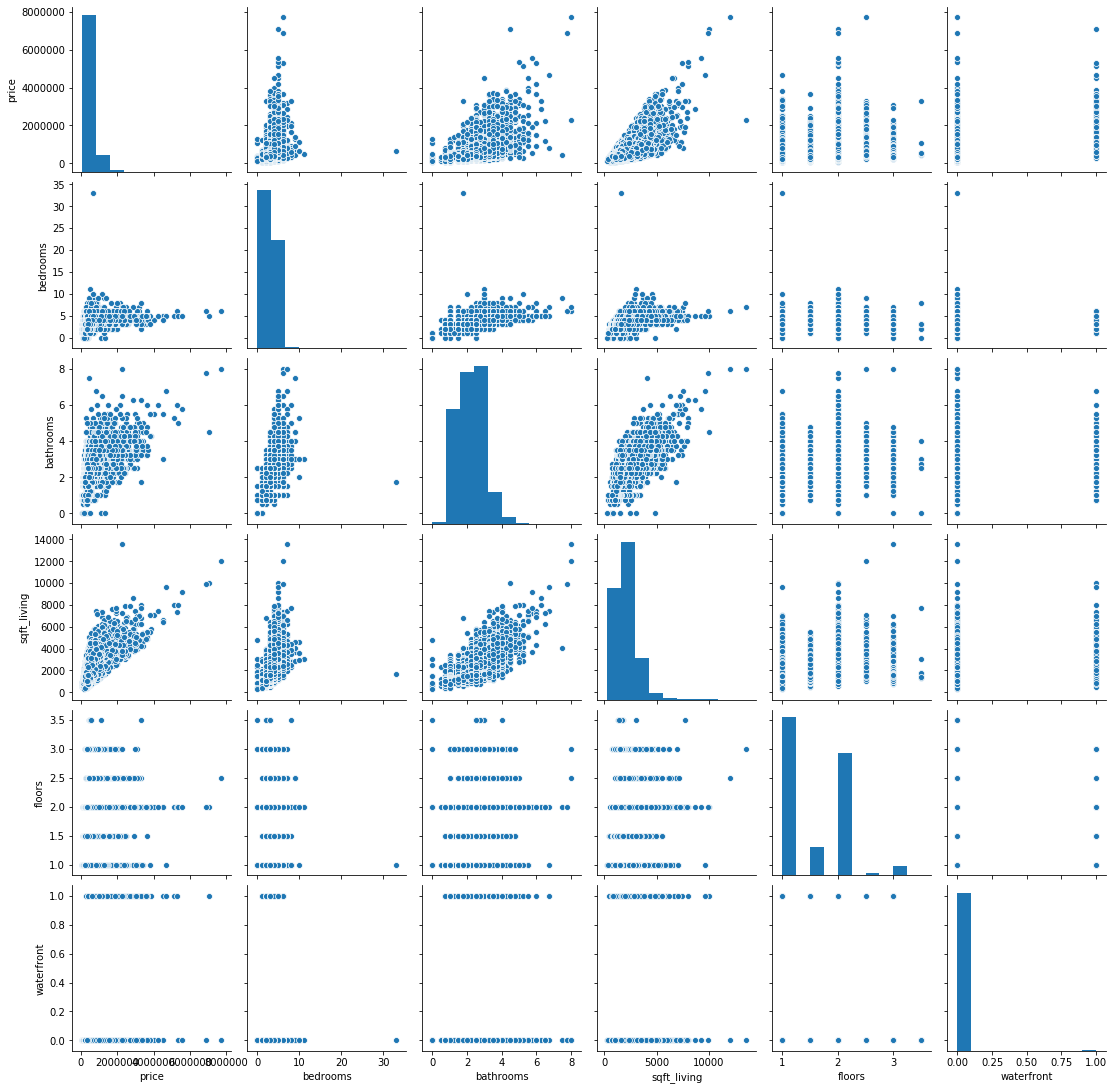

<IPython.core.display.Javascript object>

In [8]:
# answer below:
sns.pairplot(king_county)
plt.show()

There are two noticeable outliers here that will cause problems. Remove them.

In [26]:
king_county = king_county[king_county["bedrooms"] < 15]

<IPython.core.display.Javascript object>

In [20]:
king_county.sort_values(by="sqft_living", ascending=False).head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront
12777,2280000.0,2280000.0,8.00,13540,3.0,0
7252,7700000.0,7700000.0,8.00,12050,2.5,0
3914,7062500.0,7062500.0,4.50,10040,2.0,1
9254,6885000.0,6885000.0,7.75,9890,2.0,0
8092,4668000.0,4668000.0,6.75,9640,1.0,1


<IPython.core.display.Javascript object>

In [27]:
king_county = king_county.drop(12777)

<IPython.core.display.Javascript object>

In [22]:
king_county.sort_values(by="sqft_living", ascending=False).head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront
7252,7700000.0,7700000.0,8.00,12050,2.5,0
3914,7062500.0,7062500.0,4.50,10040,2.0,1
9254,6885000.0,6885000.0,7.75,9890,2.0,0
8092,4668000.0,4668000.0,6.75,9640,1.0,1
4411,5570000.0,5570000.0,5.75,9200,2.0,0


<IPython.core.display.Javascript object>

Next, we'll check for missing values and remove rows containing missing values. We will also make sure that all our data is numeric and convert the columns that are of object type to numeric. Make sure to remove any rows with missing data resulting from the conversion to numeric.

In [28]:
# answer below:
king_county.isna().mean()


price          0.0
bedrooms       0.0
bathrooms      0.0
sqft_living    0.0
floors         0.0
waterfront     0.0
dtype: float64

<IPython.core.display.Javascript object>

In [29]:
king_county.dtypes

price          float64
bedrooms         int64
bathrooms      float64
sqft_living      int64
floors         float64
waterfront       int64
dtype: object

<IPython.core.display.Javascript object>

Split the data into test and train subsets. Use 20% of the data for the test subset. Use price as the dependent variable.

In [31]:
# answer below:
X = king_county.drop(columns = ['price'])
y = king_county['price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)


<IPython.core.display.Javascript object>

Check the model assumptions: homoscedacity, normal errors, and multicollinearity

In [32]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     4060.
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:46:03   Log-Likelihood:            -2.3907e+05
No. Observations:               17288   AIC:                         4.782e+05
Df Residuals:                   17282   BIC:                         4.782e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         7.19e+04   8305.028      8.657      0.000    5.56e+04    8.82e+04
bedrooms    -5.398e+04   2609.484    -20.687      0.000   -5.91e+04   -4.89e+04
bathrooms    1.065e+04   4069.240      2.616      0.009    2670.213    1.86e+04
sqft_living   295.9152      3.326     88.961      0.000     289.395     302.435
floors       3772.1764   4010.724      0.941      0.347   -4089.250    1.16e+04
waterfront   7.701e+05   2.18e+04     35.357      0.000    7.27e+05    8.13e+05
==============================================================================
Omnibus:                    10655.174   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           358833.945
Skew:                           2.425   Prob(JB):                         0.00
Kurtosis:                      24.786   Cond. No.                     2.65e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

In [33]:
# answer below:
_, p, _, _ = het_breuschpagan(model.resid, X_train_const)
p

0.0

<IPython.core.display.Javascript object>

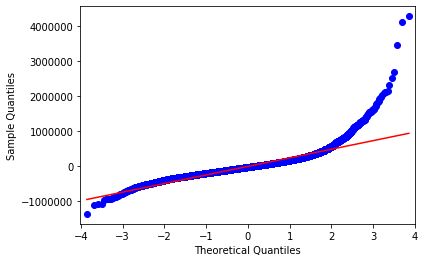

<IPython.core.display.Javascript object>

In [34]:
y_pred = model.predict(X_train_const)

sm.qqplot(model.resid, line="s")
plt.show()

In [37]:
print_vif(X_train)

VIF results
-------------------------------
const          19.820710
bedrooms        1.607796
bathrooms       2.804379
sqft_living     2.635564
floors          1.361457
waterfront      1.017459
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

Create your final linear model and produce a model summary. Look at the coefficients and interpret their meaning. How do each of them influence the final prediction?

In [45]:
# answer below
king_county = king_county[
    ["price", "bedrooms", "bathrooms", "sqft_living", "floors", "waterfront"]
]
X = king_county.drop(columns=["price", "floors"])
y = king_county["price"]

<IPython.core.display.Javascript object>

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [47]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5075.
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:57:55   Log-Likelihood:            -2.3907e+05
No. Observations:               17288   AIC:                         4.782e+05
Df Residuals:                   17283   BIC:                         4.782e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7.527e+04   7494.380     10.043      0.000    6.06e+04       9e+04
bedrooms    -5.425e+04   2593.791    -20.916      0.000   -5.93e+04   -4.92e+04
bathrooms    1.219e+04   3725.185      3.271      0.001    4884.762    1.95e+04
sqft_living   295.8876      3.326     88.957      0.000     289.368     302.407
waterfront   7.696e+05   2.18e+04     35.344      0.000    7.27e+05    8.12e+05
==============================================================================
Omnibus:                    10637.183   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           356540.449
Skew:                           2.421   Prob(JB):                         0.00
Kurtosis:                      24.715   Cond. No.                     2.65e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

Predict the y values for the test sample using our model above.

Plot the true vs. predicted values and compute the MAE, MSE, RMSE and MAPE. How accurate is our model?

In [50]:
y_pred = model.predict(X_test_const)
error = y_pred - y_test

<IPython.core.display.Javascript object>

In [52]:
# MAE
np.mean(np.abs(error))


171725.04362214604

<IPython.core.display.Javascript object>

In [53]:
# MAPE
error = y_pred - y_test
percent_error = error / y_test
np.mean(np.abs(percent_error))

0.34706404319155054

<IPython.core.display.Javascript object>

In [54]:
# RMSE
error = y_pred - y_test
squared_error = error ** 2
mean_squared_error = np.mean(squared_error)

np.sqrt(mean_squared_error)

259340.3676465256

<IPython.core.display.Javascript object>

In [56]:
# MSE
error = y_pred - y_test
squared_error = error ** 2
np.mean(squared_error)

67257426291.03507

<IPython.core.display.Javascript object>